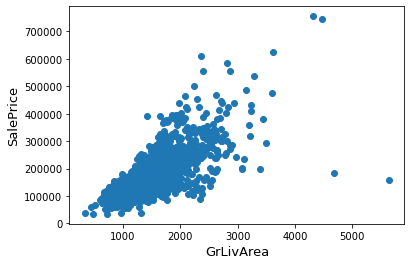

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
dirname=os.getcwd()
data_dir=os.path.join(dirname,"house-prices-advanced-regression-techniques")
train_path = os.path.join(data_dir,"train.csv")
test_path = os.path.join(data_dir,"test.csv")
x_train = pd.read_csv(str(train_path))
x_test = pd.read_csv(str(test_path))
fig, ax = plt.subplots()
ax.scatter(x = x_train['GrLivArea'], y = x_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()   


In [10]:
#drop outlier
x_train = x_train.drop(x_train[(x_train['GrLivArea']>4000)].index)
train_ID = x_train['Id']
test_ID = x_test['Id']   
x_train.drop('Id', axis = 1, inplace = True)
x_test.drop('Id', axis = 1, inplace = True)
train = x_train.shape[0]
# data smoothing
x_train["SalePrice"] = np.log1p(x_train["SalePrice"])
y_train = x_train.pop('SalePrice')
y_train = pd.DataFrame(y_train)
all_data = pd.concat((x_train,x_test)).reset_index(drop=True)

In [11]:
corrmat = x_train.corr()
f, ax = plt.subplots(figsize=(12, 9)
sns.heatmap(corrmat, vmax=.8, square=True)

SyntaxError: invalid syntax (<ipython-input-11-53a3804e8207>, line 3)

In [12]:
nullChecker= all_data.isnull().sum()
nullChecker[nullChecker>0].sort_values(ascending=False)
print(nullChecker)
# Impute Nan values according to data_description.txt
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None") 
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None") 
all_data['FireplaceQu']=all_data['FireplaceQu'].fillna(all_data['FireplaceQu'].mode()[0])
all_data['LotFrontage']=all_data['LotFrontage'].fillna(all_data['LotFrontage'].median())
all_data['GarageYrBlt']=all_data['GarageYrBlt'].fillna(0)
all_data['GarageType']=all_data['GarageType'].fillna("None")
all_data['GarageFinish']=all_data['GarageFinish'].fillna("None")
all_data['GarageQual']=all_data['GarageQual'].fillna("None")
all_data['GarageCond']=all_data['GarageCond'].fillna("None")
all_data['BsmtFinType2']=all_data['BsmtFinType2'].fillna("None")
all_data['BsmtExposure']=all_data['BsmtExposure'].fillna("None")
all_data['BsmtFinType1']=all_data['BsmtFinType1'].fillna("None")
all_data['BsmtCond']=all_data['BsmtCond'].fillna("None")
all_data['BsmtQual']=all_data['BsmtQual'].fillna("None")
all_data['MasVnrArea']=all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType']=all_data['MasVnrType'].fillna("None")
all_data['Electrical']=all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['MSZoning']=all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Functional']=all_data['Functional'].fillna(all_data['Functional'].mode()[0])
all_data['SaleType']=all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['GarageArea']=all_data['GarageArea'].fillna(0)
all_data['GarageCars']=all_data['GarageCars'].fillna(0)
all_data['KitchenQual']=all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['TotalBsmtSF']=all_data['TotalBsmtSF'].fillna(0)
all_data['BsmtUnfSF']=all_data['BsmtUnfSF'].fillna(0)
all_data['BsmtFinSF2']=all_data['BsmtFinSF2'].fillna(0)
all_data['BsmtFinSF1']=all_data['BsmtFinSF1'].fillna(0)
all_data['Exterior2nd']=all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['Exterior1st']=all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['BsmtHalfBath']=all_data['BsmtHalfBath'].fillna(0)
all_data['BsmtFullBath']=all_data['BsmtFullBath'].fillna(0)
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
#Feature engineering
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] 
nullChecker2= all_data.isnull().sum()
nullChecker2[nullChecker2>0].sort_values(ascending=False)
print(nullChecker2)
# data smoothing
for feature in all_data:
    if all_data[feature].dtype != "object":
            all_data[feature] = np.log1p(all_data[feature])
                
#encoding
categorical_features =['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallQual','OverallCond', 'YrSold', 'MoSold','MSSubClass']

for category in categorical_features:
    label = LabelEncoder() 
    label.fit(list(all_data[category].values))
    all_data[category] = label.transform(list(all_data[category].values))

all_data = pd.get_dummies(all_data)
x_train = all_data[:train]
x_test = all_data[train:]

MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 79, dtype: int64
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
TotalSF          0
Length: 80, dtype: int64


In [13]:
model = lgb.LGBMRegressor(objective='regression',num_leaves=12,max_bin=100,num_iterations=2000,learning_rate=0.01,min_data_in_leaf=10,bagging_fraction=0.8,bagging_freq=5,feature_fraction=0.23)
model.fit(x_train, y_train)
prediction = np.expm1(model.predict(x_test))#data smoothing
result = pd.DataFrame()
result['Id'] = test_ID
result['SalePrice'] = prediction
result.to_csv('submission_LGB_tunned.csv',index=False)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.23, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
